Import required modules

In [1]:
import cv2
import gc
import glob
import itertools
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import patient_data
import pydicom
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-17 05:09:47.553436: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 05:09:47.568997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734412187.587645     548 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734412187.593243     548 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 05:09:47.612645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Access the folder path for the cancer and the non-cancer images

In [2]:
all_paths = json.loads(open("./paths.json").read())

personal_path = all_paths['personal_path']
cancerous_path = personal_path + all_paths['cancerous_path']

Configure GPUs is applicable

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) > 0:
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)

Num GPUs Available:  2


Load in all the DICOM files and preprocess/label images

In [4]:
# Using the patient_data data structure, load in all the patient data and save it in a dictionary with the folder name as the key
def load_all_patients(path, add_label = False):
    patients = np.array([])
    folder = os.listdir(path)
    # make shuffling and train/test split here
    for name in folder:
        patients= np.append(patients, patient_data.Patient(path, name, add_label))
        if patients[-1].ct_paths == []:
            print(name, "was not processed correctly")
            patients = patients[:-1]
    return patients

patients = load_all_patients(cancerous_path, True)

.ipynb_checkpoints was not processed correctly


In [5]:
num_nc = 0
num_c = 0
for i in patients:
    num_nc += sum(1 for j in i.labels if j ==0)   
    num_c += sum(1 for j in i.labels if j ==1)  

print("number of patients loaded:", len(patients))
print("number of non-cancerous images in this dataset:", num_nc)
print("number of cancerous images in this dataset:", num_c)

number of patients loaded: 422
number of non-cancerous images in this dataset: 46726
number of cancerous images in this dataset: 7610


Setting up train/test data

In [11]:
# mix up the data
patients = shuffle(patients)

# Train-test split should be 80-20. 
# Since the data has been shuffled, we can just grab the 1st 80% of the list and make it the train set and the remainder is the test set
train_patients = patients[:math.floor(len(patients) * 0.8)]
test_patients = patients[math.floor(len(patients) * 0.8):]

def save_imgs(dest, list_paths, list_labels):
    cancerous_img_folder = dest + "/cancerous"
    non_cancerous_img_folder = dest + "/non_cancerous"
    if not os.path.exists(cancerous_img_folder):
        os.makedirs(cancerous_img_folder)
    if not os.path.exists(non_cancerous_img_folder):
        os.makedirs(non_cancerous_img_folder)
    # for our purposes, we know we dont want these folders to have any previous content, so remove anything in here if there is something
    for file in glob.glob(cancerous_img_folder + "/*"):
        os.remove(file)
    for file in glob.glob(non_cancerous_img_folder + "/*"):
        os.remove(file)
    # save images
    for i, dicom_path in enumerate(list_paths):
        if list_labels[i] == 0:
            img_folder = non_cancerous_img_folder
        else:
            img_folder = cancerous_img_folder
        dicom = pydicom.dcmread(dicom_path)
        pix_array = dicom.pixel_array
        img = cv2.normalize(pix_array, None, 0, 255, cv2.NORM_MINMAX)
        cv2.imwrite(f"{img_folder}/image_{i}.jpg", img)

train_dest = personal_path + "/train/train"
val_dest = personal_path + "/train/validation"
test_dest = personal_path + "/test"


# save_imgs(train_dest, train_patients)
x_test, y_test = [], []
for patient in test_patients:
    x_test.extend(patient.ct_paths)
    y_test.extend(patient.labels)
save_imgs(test_dest, x_test, y_test)
test_ds = ImageDataGenerator().flow_from_directory(
        directory=test_dest, # the path to the test directory.
        target_size=(512, 512),
        batch_size=32,
        class_mode="binary",
        shuffle = False
    )

# split the train patients up into images and labels
x_train, y_train = [], []
for patient in train_patients:
    x_train.extend(patient.ct_paths)
    y_train.extend(patient.labels)
x_train, y_train = np.array(x_train), np.array(y_train)
x_train, y_train = shuffle(x_train, y_train)

del train_patients
del test_patients
del patients
# del x_test
# del y_test
# del x_train
# del y_train

NameError: name 'patients' is not defined

Create a custom callback to clear any memory that is no longer being used

In [7]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect
        tf.keras.backend.clear_session()

In [22]:
# Define K-Fold Cross-Validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
    print(f"\nTraining fold {fold + 1}/{n_splits}")
    
    x_train_list, y_train_list = x_train[train_idx], y_train[train_idx]
    x_val_list, y_val_list = x_train[val_idx], y_train[val_idx]

    save_imgs(train_dest, x_train_list, y_train_list)
    save_imgs(val_dest, x_val_list, y_val_list)   
        
    # Load the ResNet50 model pre-trained on ImageNet
    model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(512, 512, 3)))
    
    # Custom layers
    flattened = tf.keras.layers.Flatten()(model.output)
    l2 = tf.keras.layers.Dense(128, activation='relu')(flattened)
    l3 = tf.keras.layers.Dense(1, activation='sigmoid')(l2)
    
    # Define the full model
    model = tf.keras.models.Model(inputs=model.input, outputs=l3)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00001),  # Use a smaller learning rate for end-to-end training
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    train_ds = ImageDataGenerator().flow_from_directory(
            directory=train_dest, # the path to the training directory.
            target_size=(512, 512),
            batch_size=64,
            class_mode="binary",
        )
    val_ds = ImageDataGenerator().flow_from_directory(
            directory=val_dest, # the path to the validation directory.
            target_size=(512, 512),
            batch_size=64,
            class_mode="binary",
        )
    

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)
    
    # Train the model directly using the training and validation data
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    # Evaluate the model
    predictions = (model.predict(test_ds) > 0.5).astype("int32")
    report = classification_report(test_ds.classes, predictions, output_dict=True)
    print(classification_report(test_ds.classes, predictions))
    
    # Save fold results
    fold_results.append(report)
    K.clear_session()

# Aggregate results
avg_accuracy = np.mean([fold['accuracy'] for fold in fold_results])
print(f"\nAverage Accuracy Across {n_splits} Folds: {avg_accuracy:.4f}")



Training fold 1/5
Found 35009 images belonging to 2 classes.
Found 8753 images belonging to 2 classes.


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1426']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


548/548 ━━━━━━━━━━━━━━━━━━━━ 465s 780ms/step - accuracy: 0.8847 - loss: 0.3257 - val_accuracy: 0.9159 - val_loss: 0.1874 - learning_rate: 1.0000e-05
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 743ms/step - accuracy: 0.9807 - loss: 0.0574 - val_accuracy: 0.9669 - val_loss: 0.0847 - learning_rate: 1.0000e-05
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/step - accuracy: 0.9959 - loss: 0.0176 - val_accuracy: 0.9709 - val_loss: 0.0732 - learning_rate: 1.0000e-05
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 740ms/step - accuracy: 0.9989 - loss: 0.0065 - val_accuracy: 0.9648 - val_loss: 0.0941 - learning_rate: 1.0000e-05
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accuracy: 0.9729 - val_loss: 0.0762 - learning_rate: 1.0000e-05
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 741ms/step - accuracy: 0.9991 - loss: 0.0043 - val_accuracy: 0.9717 - val_loss: 0.0794 - learning_rate: 1.0000e-05
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 741ms/

/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1426']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


331/331 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step
              precision    recall  f1-score   support

           0       0.58      0.39      0.47      1599
           1       0.90      0.95      0.92      8975

    accuracy                           0.87     10574
   macro avg       0.74      0.67      0.70     10574
weighted avg       0.85      0.87      0.85     10574


Training fold 2/5
Found 35009 images belonging to 2 classes.
Found 8753 images belonging to 2 classes.


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


548/548 ━━━━━━━━━━━━━━━━━━━━ 461s 772ms/step - accuracy: 0.8884 - loss: 0.3098 - val_accuracy: 0.9199 - val_loss: 0.1848 - learning_rate: 1.0000e-05
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/step - accuracy: 0.9784 - loss: 0.0601 - val_accuracy: 0.9702 - val_loss: 0.0744 - learning_rate: 1.0000e-05
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/step - accuracy: 0.9950 - loss: 0.0184 - val_accuracy: 0.9746 - val_loss: 0.0648 - learning_rate: 1.0000e-05
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 741ms/step - accuracy: 0.9979 - loss: 0.0085 - val_accuracy: 0.9680 - val_loss: 0.0827 - learning_rate: 1.0000e-05
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 406s 741ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 0.9690 - val_loss: 0.0899 - learning_rate: 1.0000e-05
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 744ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9774 - val_loss: 0.0613 - learning_rate: 1.0000e-05
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/

/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


331/331 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step
              precision    recall  f1-score   support

           0       0.56      0.42      0.48      1599
           1       0.90      0.94      0.92      8975

    accuracy                           0.86     10574
   macro avg       0.73      0.68      0.70     10574
weighted avg       0.85      0.86      0.85     10574


Training fold 3/5
Found 35010 images belonging to 2 classes.
Found 8752 images belonging to 2 classes.


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


548/548 ━━━━━━━━━━━━━━━━━━━━ 471s 789ms/step - accuracy: 0.8757 - loss: 0.3438 - val_accuracy: 0.9186 - val_loss: 0.1833 - learning_rate: 1.0000e-05
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 743ms/step - accuracy: 0.9756 - loss: 0.0692 - val_accuracy: 0.9592 - val_loss: 0.0972 - learning_rate: 1.0000e-05
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 743ms/step - accuracy: 0.9951 - loss: 0.0195 - val_accuracy: 0.9746 - val_loss: 0.0635 - learning_rate: 1.0000e-05
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/step - accuracy: 0.9976 - loss: 0.0094 - val_accuracy: 0.9601 - val_loss: 0.1124 - learning_rate: 1.0000e-05
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy: 0.9782 - val_loss: 0.0568 - learning_rate: 1.0000e-05
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9790 - val_loss: 0.0584 - learning_rate: 1.0000e-05
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 743ms/

/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


331/331 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step
              precision    recall  f1-score   support

           0       0.57      0.45      0.50      1599
           1       0.91      0.94      0.92      8975

    accuracy                           0.86     10574
   macro avg       0.74      0.69      0.71     10574
weighted avg       0.85      0.86      0.86     10574


Training fold 4/5
Found 35010 images belonging to 2 classes.
Found 8752 images belonging to 2 classes.


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


548/548 ━━━━━━━━━━━━━━━━━━━━ 464s 777ms/step - accuracy: 0.8922 - loss: 0.2614 - val_accuracy: 0.9230 - val_loss: 0.1782 - learning_rate: 1.0000e-05
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/step - accuracy: 0.9805 - loss: 0.0522 - val_accuracy: 0.9749 - val_loss: 0.0622 - learning_rate: 1.0000e-05
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 744ms/step - accuracy: 0.9953 - loss: 0.0166 - val_accuracy: 0.9762 - val_loss: 0.0597 - learning_rate: 1.0000e-05
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/step - accuracy: 0.9975 - loss: 0.0098 - val_accuracy: 0.9774 - val_loss: 0.0623 - learning_rate: 1.0000e-05
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9808 - val_loss: 0.0560 - learning_rate: 1.0000e-05
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 441s 742ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9737 - val_loss: 0.0828 - learning_rate: 1.0000e-05
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/

/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


331/331 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step
              precision    recall  f1-score   support

           0       0.59      0.31      0.41      1599
           1       0.89      0.96      0.92      8975

    accuracy                           0.86     10574
   macro avg       0.74      0.64      0.67     10574
weighted avg       0.84      0.86      0.84     10574


Training fold 5/5
Found 35010 images belonging to 2 classes.
Found 8752 images belonging to 2 classes.


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


548/548 ━━━━━━━━━━━━━━━━━━━━ 465s 779ms/step - accuracy: 0.8872 - loss: 0.3239 - val_accuracy: 0.9192 - val_loss: 0.2015 - learning_rate: 1.0000e-05
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/step - accuracy: 0.9812 - loss: 0.0564 - val_accuracy: 0.9673 - val_loss: 0.0795 - learning_rate: 1.0000e-05
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 743ms/step - accuracy: 0.9959 - loss: 0.0171 - val_accuracy: 0.9690 - val_loss: 0.0870 - learning_rate: 1.0000e-05
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 743ms/step - accuracy: 0.9987 - loss: 0.0066 - val_accuracy: 0.9706 - val_loss: 0.0809 - learning_rate: 1.0000e-05
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 409s 746ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9711 - val_loss: 0.0723 - learning_rate: 1.0000e-05
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 407s 742ms/step - accuracy: 0.9991 - loss: 0.0044 - val_accuracy: 0.9777 - val_loss: 0.0651 - learning_rate: 1.0000e-05
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 408s 744ms/

/home/jovyan/conda-envs/venv2/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


331/331 ━━━━━━━━━━━━━━━━━━━━ 55s 156ms/step
              precision    recall  f1-score   support

           0       0.58      0.40      0.47      1599
           1       0.90      0.95      0.92      8975

    accuracy                           0.86     10574
   macro avg       0.74      0.67      0.70     10574
weighted avg       0.85      0.86      0.85     10574


Average Accuracy Across 5 Folds: 0.8640


In [23]:
# Define K-Fold Cross-Validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# x_data = np.array(x_c)/255  # Normalize the images
# y_data = np.array(y_c)
# Model training and evaluation loop
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_patients, [0]*len(train_patients))):
    print(f"\nTraining fold {fold + 1}/{n_splits}")
    
    # Split data
    p_train, p_val = train_patients[train_idx], train_patients[val_idx]
    print('point a passed')

#     # possible model to test
#     model = Sequential([
#         Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(512, 512, 1)),
#         MaxPool2D(pool_size=(2, 2), strides=2),
#         Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
#         MaxPool2D(pool_size=(2, 2), strides=2),
#         Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same'),
#         MaxPool2D(pool_size=(2, 2), strides=1),
#         Flatten(),
#         Dense(units=1, activation='sigmoid')
#     ])
    # Build the model
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(512, 512, 1)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print('point b passed')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    x_train = []
    y_train = np.array([])
    for p in p_train:
        x_train.extend(y for y in p.ct.data.values())
        y_train = np.append(y_train, p.labels)
    x_train, y_train = shuffle(x_train, y_train)
    x_train = np.asarray(x_train)

    x_val = []
    y_val = np.array([])
    for p in p_val:
        x_val.extend(y for y in p.ct.data.values())
        y_val = np.append(y_val, p.labels)
    x_val, y_val = shuffle(x_val, y_val)
    x_val = np.asarray(x_val)
    
    datagen = ImageDataGenerator()

    train_generator = datagen.flow(x_train, y_train, batch_size=16)
    val_generator = datagen.flow(x_val, y_val, batch_size=16)

    # Train the model
    model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        batch_size=32,
        epochs=20,
        callbacks=[MyCustomCallback()],
        verbose=1
    )
    print("Model architecture built")
    # Evaluate the model
    predictions = (model.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, predictions, output_dict=True)
    print(classification_report(y_test, predictions))
    
    # Save fold results
    fold_results.append(report)
    K.clear_session()

# Aggregate results
avg_accuracy = np.mean([fold['accuracy'] for fold in fold_results])
print(f"\nAverage Accuracy Across {n_splits} Folds: {avg_accuracy:.4f}")

NameError: name 'train_patients' is not defined

Confusion matrix to visualize results of the last fold

Confusion matrix, without normalization
[[ 633  966]
 [ 463 8512]]


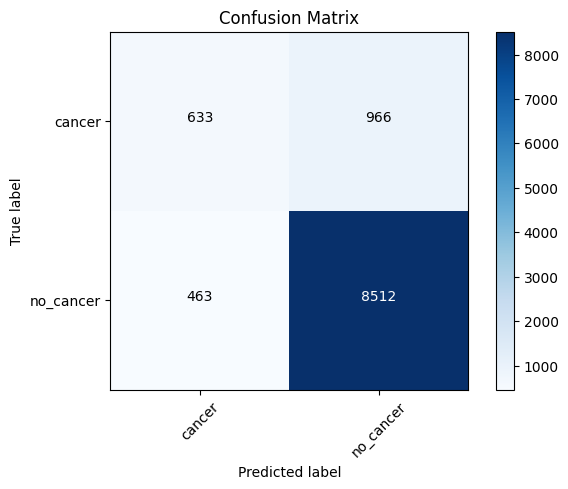

In [27]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true=test_ds.classes, y_pred=predictions)
cm_plot_labels = ['cancer','no_cancer']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Train and test CNN model

In [ ]:

# num_tests = 1
# cnns = []
# for i in range(num_tests):
# cnns.append(cnn.CNN(x_train, x_test, y_train, y_test))

Cross validation and bootstrapping

In [ ]:
# print(cnns[0].test_acc)